<a href="https://colab.research.google.com/github/ishathombre/ASBA/blob/main/Task1_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Deep Learning 2024 - Assignment 2***

**This Notebook contains our code to finetune huggingfaces models for Sentiment Analysis encoding also the aspect in the input.**

## Imports

In [ ]:
!pip install transformers datasets evaluate peft sentencepiece accelerate torch torchvision --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import xml.etree.ElementTree as ET
from xml.dom import minidom

from transformers import BertModel, BertTokenizer, BertConfig, BertForSequenceClassification, AdamW, AutoTokenizer
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification, RobertaConfig
from transformers import DebertaForSequenceClassification, DebertaConfig, DebertaTokenizer, get_scheduler
from transformers import TrainingArguments, Trainer, TrainerCallback

from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
import torch.nn as nn

from sklearn.metrics import accuracy_score
import evaluate
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

##Data download, parsing and inspection

Datasets downloaded from https://alt.qcri.org/semeval2014/task4/ Semeval2014 Task 4 (ABSA).

**We first clone our repository with all the data and the scripts.**

In [ ]:
!git clone https://github.com/ishathombre/ASBA.git

Cloning into 'ASBA'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 265 (delta 66), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (265/265), 1.77 MiB | 2.43 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
%cd ASBA
xml_rest = 'Datasets/Restaurants_Train_v2.xml'
xml_lapt = 'Datasets/Laptop_Train_v2.xml'

/content/ASBA


**We parse the xml data and convert them into dataframes**

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET

def xml_to_df(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    data = []
    for sentence in root.findall('sentence'):
        sentence_id = sentence.get('id')
        text = sentence.find('text').text

        aspect_terms = sentence.find('aspectTerms')
        if aspect_terms is not None:
            for aspect_term in aspect_terms.findall('aspectTerm'):
                term = aspect_term.get('term')
                polarity = aspect_term.get('polarity')
                from_index = aspect_term.get('from')
                to_index = aspect_term.get('to')
                data.append([sentence_id, text, term, polarity, from_index, to_index])
        else:
            data.append([sentence_id, text, None, None, None, None])

    df = pd.DataFrame(data, columns=['sentence_id', 'text', 'term', 'polarity', 'from_index', 'to_index'])
    return df

#OR

def parse_data_2014(xml_file):
    container = []  # Initialize Container (List) for Parse Data
    sentences = ET.parse(xml_file).getroot()  # Get Sentence-Level Nodes

    for sentence in sentences:  # Loop Through Sentences
        sentence_id = sentence.attrib["id"]  # Save ID
        sentence_text = sentence.find('text').text  # Save Text
        aspects = sentence.findall('*')  # Get Aspect-Level Nodes

        found_category = False

        for aspect in aspects:  # Loop Through Aspects
            if aspect.tag == "aspectCategories":
                opinions = aspect.findall('*')  # Get Opinion-Level Nodes
                for opinion in opinions:
                    category = opinion.attrib["category"]
                    polarity = opinion.attrib.get("polarity", np.nan)
                    row = {"sentence_id": sentence_id, "sentence": sentence_text, "category": category, "polarity": polarity}
                    container.append(row)
                found_category = True

        if not found_category:
            row = {"sentence_id": sentence_id, "sentence": sentence_text, "category": np.nan, "polarity": np.nan}
            container.append(row)

    return pd.DataFrame(container)

In [ ]:
# now we convert the xml to df
rests = parse_data_2014(xml_rest)
rest_ = xml_to_df(xml_rest)
lapts = xml_to_df(xml_lapt)
#df = pd.concat([rests, lapts], ignore_index=True)

In [ ]:
# Data Inspection
rests['polarity'].value_counts()

polarity
positive    2179
negative     839
neutral      500
conflict     195
Name: count, dtype: int64

In [ ]:
lapts['polarity'].value_counts()

In [ ]:
rests['category'].value_counts()

category
food                       1232
anecdotes/miscellaneous    1132
service                     597
ambience                    431
price                       321
Name: count, dtype: int64

In [ ]:
lapts['term'].value_counts()

**We see that we have a lot of terms/aspects in both the datasets, however just few aspects have an high frequency and to simplify the classification we will focus on those ones, namely: *'service', 'food', 'anecdotes/miscellaneous', 'price', 'ambience'*.**

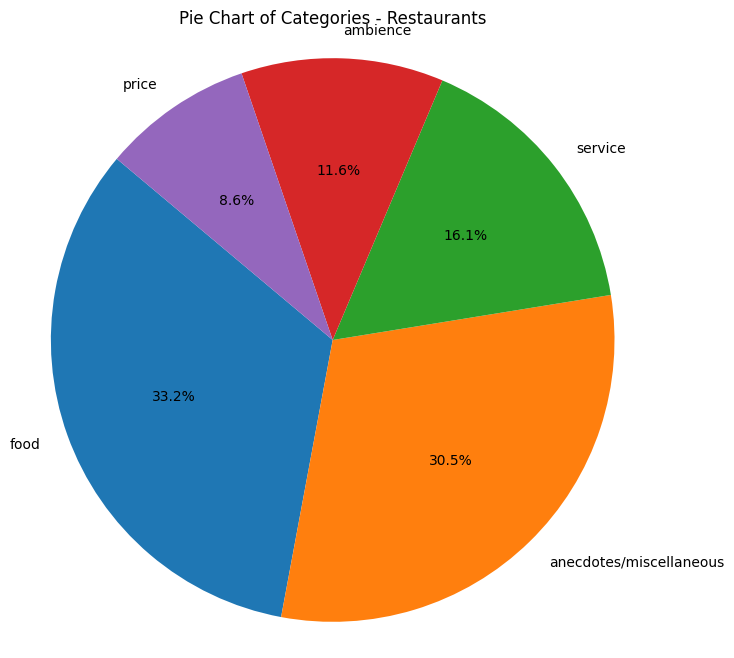

In [ ]:
import matplotlib.pyplot as plt

# Pie plot to see the frequencies of apsects
value_counts = rests['category'].value_counts()

# Extract labels and frequencies
labels = value_counts.index.tolist()
frequencies = value_counts.values.tolist()

# Plotting the pie chart
plt.figure(figsize=(8, 8))  # Set the size of the plot
plt.pie(frequencies, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart of Categories - Restaurants')
plt.savefig('aspectspie.png')
plt.show()


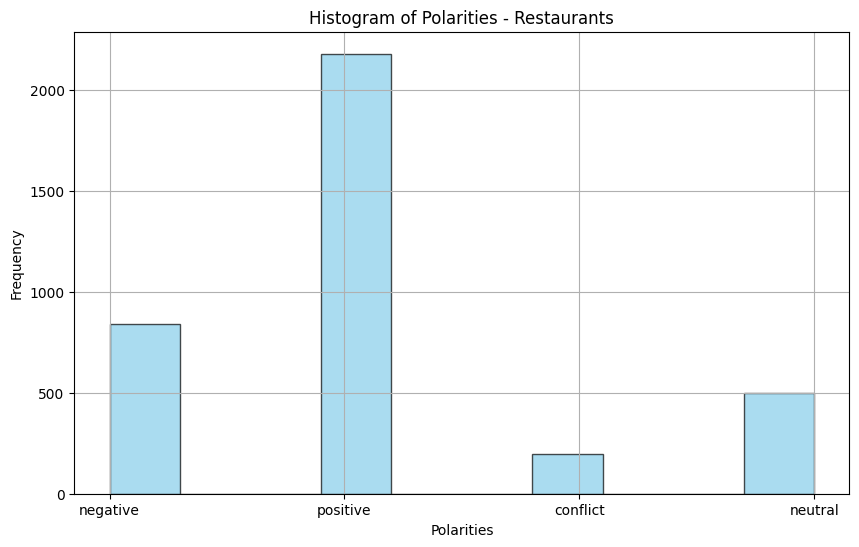

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(rests['polarity'], color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Polarities - Restaurants')
plt.xlabel('Polarities')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('polaritieshist.png')
plt.show()

In [ ]:
rests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3713 entries, 0 to 3712
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  3713 non-null   object
 1   sentence     3713 non-null   object
 2   category     3713 non-null   object
 3   polarity     3713 non-null   object
dtypes: object(4)
memory usage: 116.2+ KB


In [ ]:
# resulting DF
df = rests
todrop=['sentence_id']
df.drop(columns=todrop, inplace=True)
df.head(10)

,sentence,category,polarity
0,But the staff was so horrible to us.,service,negative
1,"To be completely fair, the only redeeming fact...",food,positive
2,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative
3,"The food is uniformly exceptional, with a very...",food,positive
4,Where Gabriela personaly greets you and recomm...,service,positive
5,"For those that go once and don't enjoy it, all...",anecdotes/miscellaneous,positive
6,"Not only was the food outstanding, but the lit...",food,positive
7,"Not only was the food outstanding, but the lit...",service,positive
8,It is very overpriced and not very tasty.,food,negative
9,It is very overpriced and not very tasty.,price,negative


##Dataset tokenization and encoding

In [ ]:
# Define the class to encode dataset and function to slpit the dataset in train, val and test
# plus define function to encode training data

class ABSA_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def merge_sent(list1, list2):
    merged_ = []
    for x, y in zip(list1, list2):
        merged_.append(x + " [SEP] " + str(y))
    return merged_

def split_dataframe(df, train_percent=0.7, val_percent=0.15, test_percent=0.15):

    if train_percent + val_percent + test_percent != 1.0:
        raise ValueError("The sum of train_percent, val_percent, and test_percent must be equal to 1.0.")

    # Shuffle the DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

    # Calculate split indices
    total_samples = len(df)
    train_end = int(train_percent * total_samples)
    val_end = train_end + int(val_percent * total_samples)

    # Split the DataFrame
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    return train_df, val_df, test_df


def setup_data(tokenizer, train_df, eval_df, test_df):

    label_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'conflict': 3}
    label_map_category = {'service': 4, 'food': 5,'anecdotes/miscellaneous': 6,'price': 7, 'ambience': 8 }

    train_texts = train_df['sentence']
    train_labels = train_df['polarity']
    train_labels_category = train_df['category']
    train_labels = [label_map[label_] for label_ in train_labels]
    train_labels_category = [label_map_category[label] for label in train_labels_category]


    eval_texts = eval_df['sentence']
    eval_labels = eval_df['polarity']
    eval_labels_category = eval_df['category']
    eval_labels = [label_map[label_] for label_ in eval_labels]
    eval_labels_category = [label_map_category[label] for label in eval_labels_category]

    test_texts = test_df['sentence']
    test_labels = test_df['polarity']
    test_labels_category = test_df['category']
    test_labels = [label_map[label_] for label_ in test_labels]
    test_labels_category = [label_map_category[label] for label in test_labels_category]

    # Since DeBERTa does not accept 2 labels as input, I'm including the categories in the text embeddings
    # separated by a special tokens [SEP]
    train_ = merge_sent(train_texts, train_labels_category)
    eval_ = merge_sent(eval_texts, eval_labels_category)
    test_ = merge_sent(test_texts, test_labels_category)

    # train_encodings = tokenizer(str(train_texts), padding="max_length", truncation=True, max_length=512)
    # eval_encodings = tokenizer(str(eval_texts), padding="max_length", truncation=True, max_length=512)
    # test_encodings = tokenizer(str(test_texts), padding="max_length", truncation=True, max_length=512)

    train_encodings = tokenizer(train_, padding="max_length", truncation=True, max_length=512)
    eval_encodings = tokenizer(eval_, padding="max_length", truncation=True, max_length=512)
    test_encodings = tokenizer(test_, padding="max_length", truncation=True, max_length=512)

    #train_labels = [train_labels, train_labels_category]
    #eval_labels = [eval_labels, eval_labels_category]

    train_dataset = ABSA_Dataset(train_encodings, train_labels)
    val_dataset = ABSA_Dataset(eval_encodings, eval_labels)

    return train_dataset, val_dataset, test_


Make encodings  of text sequences and labels to feed the model.

In [ ]:
# # use csv datasets in the repository to make results reproducible
# train_df = pd.read_csv('/content/ASBA/Datasets/restaurants_train.csv', sep='|')
# val_df = pd.read_csv('/content/ASBA/Datasets/restaurants_val.csv', sep='|')
# test_df = pd.read_csv('/content/ASBA/Datasets/restaurants_test.csv', sep='|')

In [ ]:
train_df, val_df, test_df = split_dataframe(df, train_percent=0.7, val_percent=0.15, test_percent=0.15)

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

# splitting the data
train_df, val_df, test_df = split_dataframe(df, train_percent=0.7, val_percent=0.15, test_percent=0.15)
# encoding data for training
train_dataset, val_dataset, test_ = setup_data(tokenizer, train_df, val_df, test_df)

#train_df.to_csv('restaurants_train.csv', sep='|', index=False)
#val_df.to_csv('restaurants_val.csv', sep='|', index=False)
#test_df.to_csv('restaurants_test.csv', sep='|', index=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [ ]:
train_dataset.encodings

In [ ]:
train_dataset.labels

##Model and Training

In [ ]:
# we first mount to drive to store the output there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# empty cuda cache if needed
import torch
torch.cuda.empty_cache()

In [ ]:
# check the configuration of the model
config = DebertaConfig(torchscript=True)
#config = BertConfig(torchscript=True)
print(config)

DebertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": null,
  "position_biased_input": true,
  "relative_attention": false,
  "torchscript": true,
  "transformers_version": "4.38.2",
  "type_vocab_size": 0,
  "vocab_size": 50265
}



In [ ]:
# define the model and nr of labels
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=4)
#model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base",  config=config, num_labels=4)
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# we define the metrics to be computed during training, the crossnetropy loss and accuracy.
from torch.nn import CrossEntropyLoss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    loss = torch.nn.CrossEntropyLoss()(torch.tensor(logits), torch.tensor(labels)).item()
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    return {"loss": loss, "accuracy": accuracy}

In [ ]:
# we define the training loop and arguments under a function, using the Trainer from huggigfaces
from transformers import TrainerCallback
import torch
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

# Training function
# def training_run(model, output_dir, num_epochs, batch_size, train_dataset, val_dataset):

#     epochs = 3
#     batch_size = 8
#     num_steps = len(train_dataset) * epochs // batch_size
#     warmup_steps = num_steps // 10  # 10% of the training steps
#     save_steps = num_steps // epochs
#     #optimizer = AdamW(model.parameters(), lr=5e-5)
#     #criterion = CrossEntropyLoss()


#     training_args = TrainingArguments(
#         output_dir=output_dir,
#         num_train_epochs = epochs,
#         per_device_train_batch_size = batch_size,
#         per_device_eval_batch_size = batch_size,
#         warmup_steps = warmup_steps,
#         weight_decay = 0.01,
#         logging_dir = 'logs',
#         logging_steps = 10,
#         evaluation_strategy = 'steps',
#         do_eval = True,
#         learning_rate = 5e-5, #0.00005
#         save_steps = save_steps)

#     trainer = Trainer(model,
#                       training_args,
#                       #optimizers=optimizer,
#                       train_dataset=train_dataset,
#                       eval_dataset=val_dataset,
#                       compute_metrics=compute_metrics)


#     # Start training
#     trainer.train()

#     return trainer


In [ ]:
from transformers import TrainerCallback
import torch
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

class CustomCallback(TrainerCallback):

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

epochs = 3
batch_size = 8
num_steps = len(train_dataset) * epochs // batch_size
warmup_steps = num_steps // 10  # 10% of the training steps
save_steps = num_steps // epochs
#optimizer = AdamW(model.parameters(), lr=5e-5)
#criterion = CrossEntropyLoss()


training_args = TrainingArguments(
                output_dir="/content/deberta",
                num_train_epochs = epochs,
                per_device_train_batch_size = batch_size,
                per_device_eval_batch_size = batch_size,
                warmup_steps = warmup_steps,
                weight_decay = 0.01,
                logging_dir = 'logs',
                logging_steps = 10,
                evaluation_strategy = 'steps',
                do_eval = True,
                learning_rate = 5e-5, #0.00005
                save_steps = save_steps)

trainer = Trainer(model,
          training_args,
          #optimizers=optimizer,
          train_dataset=train_dataset,
          eval_dataset=val_dataset,
          compute_metrics=compute_metrics)


# Start training
trainer.add_callback(CustomCallback(trainer))
trainer.train()
#trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.378000,1.367291,0.552158
20,1.249100,1.164325,0.559353
30,1.105100,1.117132,0.553957
40,1.099100,1.114684,0.559353
50,0.976900,1.107921,0.559353
60,0.922600,1.023992,0.624101
70,0.989700,0.902503,0.687050
80,0.804500,1.168107,0.593525
90,1.017200,0.799378,0.732014
100,0.898400,0.806481,0.706835


TrainOutput(global_step=975, training_loss=0.5536441700275128, metrics={'train_runtime': 1333.6754, 'train_samples_per_second': 5.846, 'train_steps_per_second': 0.731, 'total_flos': 2390578319978496.0, 'train_loss': 0.5536441700275128, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7501965165138245,
 'eval_accuracy': 0.7859712230215827,
 'eval_runtime': 9.2729,
 'eval_samples_per_second': 59.96,
 'eval_steps_per_second': 7.549,
 'epoch': 3.0}

In [ ]:
#training_run(model, "/content/drive/MyDrive/Deberta", 3, 8, train_dataset, val_dataset)

In [ ]:
# we check the history and convert it into a df
import pandas as pd
history = pd.DataFrame(trainer.state.log_history)
#print(history)

In [ ]:
val_loss = history.groupby('epoch')['eval_loss'].mean()
tr_loss = history.groupby('epoch')['loss'].mean()

val_acc = history.groupby('epoch')['eval_accuracy'].mean()
#tr_acc = history.groupby('epoch')['accuracy'].mean()

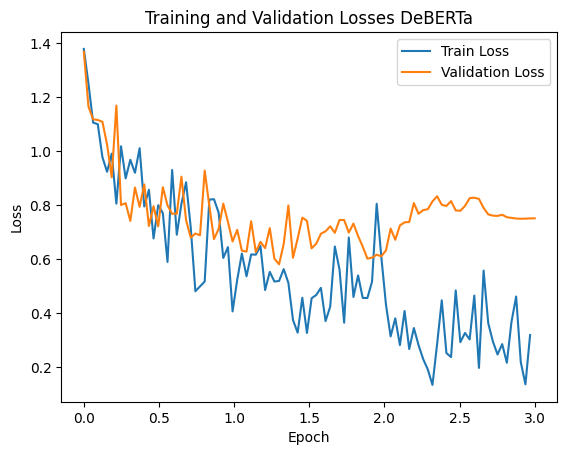

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(0, 3, num=98)
# Plotting
plt.plot(x, tr_loss, label='Train Loss')
plt.plot(x, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses DeBERTa')
plt.legend()
plt.savefig('deberta_losses.png')
plt.show()

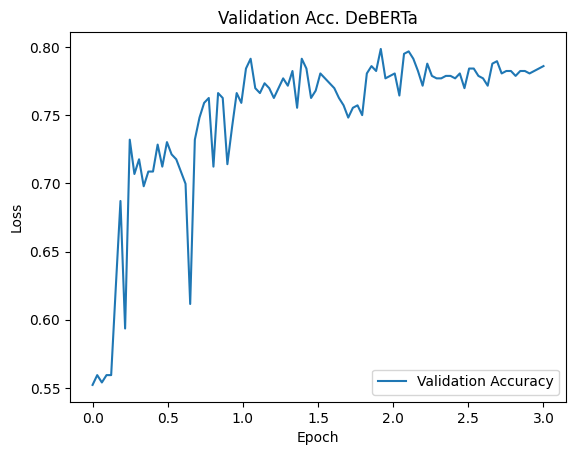

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(0, 3, num=98)
# Plotting
#plt.plot(x, tr_acc, label='Train Accuracy')
plt.plot(x, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Acc. DeBERTa')
plt.legend()
plt.savefig('deBERTa_acc.png')
plt.show()

## Testing

In [ ]:
#print(test_)

In [ ]:
# download the csvs to run testing without training the model

train_df = pd.read_csv('/content/ASBA/Datasets/restaurants_train.csv', sep='|')
val_df = pd.read_csv('/content/ASBA/Datasets/restaurants_val.csv', sep='|')
test_df = pd.read_csv('/content/ASBA/Datasets/restaurants_test.csv', sep='|')

train_dataset, val_dataset, test_ = setup_data(tokenizer, train_df, val_df, test_df)

**Download the last checkpoints for all the models**

In [ ]:
%cd ..

/content


In [ ]:
import gdown
!gdown https://drive.google.com/drive/folders/1FWky7kDjH68L9av2rYFkuBffQywvzsZy -O /content --folder

In [ ]:
# THIS CODE IS FOR TESTING, NEED TEST SPLIT
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class for testing
class TestDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        inputs = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=True,
            return_attention_mask=True,
            truncation=True
        )
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        }

tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
# Define sentences for testing
test_sentences = [
    "This movie was fantastic!",
    "The acting was terrible, but the plot was good.",
    "I did not enjoyed the movie the movie overall.",
    "I ate an apple this morning",
    "The meal was awful, but the company was precious."
    "It is very overpriced and not very tasty"
]

# Instantiate the test dataset
test_dataset = test_
#test_dataset = test_sentences
test_dataset = TestDataset(test_dataset, tokenizer, 512)

batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load the fine-tuned model
model_ = DebertaForSequenceClassification.from_pretrained('/content/deberta_972', num_labels=4)

sentences = []
predictions = []
# Perform inference on the test dataset
for batch in test_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    token_type_ids = batch['token_type_ids']

    with torch.no_grad():
        outputs = model_(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    sentences.append(tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True))
    predictions.append(predicted_label)

    # for sentence, predicted_label in zip(sentences, predictions):
    #   print("Input sentence:", sentence, "|", "Predicted label:", predicted_label)
    #   print("----")

In [ ]:
print(sentences)
# sents_ = pd.DataFrame(sentences)
# sents_ = sents_.str.split('\t')
# label_map_category = {4 : 'service', 5 : 'food', 6 :'anecdotes/miscellaneous', 7 : 'price', 8 : 'ambience' }

['Looking around, I saw a room full of New Yorkers enjoying a real meal in a real restaurant, not a clubhouse of the fabulous trying to be seen.  8', 'Everything is delicious, though, my gf and I come here once a week sometimes- you will get addicted!  6', 'The staff was accomodating, the food was absolutely delicious and the place is lovely.  4', 'This place would be so much better served by being run by a group that actually understands customer service.  4', 'The puke green walls leave a lot to be desired, but the food is very good.  8', 'Upon entering, we were greeted by the owners, Steven and Frederick, who went out of their way to be more than gracious hosts.  4', 'You can even get packages of the chutneys to stock your fridge!  4', 'And their prices are very high - they actually think that they can get away with charging such prices for such terrible food and service!  4', 'Only wine and beer are served, but the house varities are actually quite good.  5', 'Decent Thai food in c

**Evaluate the Results on the test dataset**

In [ ]:
# PRINT THE OUTPUT
label_map = {0 : 'negative',  1 : 'neutral', 2 : 'positive', 3 : 'conflict'}
predicted_labels = [label_map[label_] for label_ in predictions]


for sentence, predicted_label in zip(sentences, predicted_labels):
  print("Input sentence:", sentence, "|", "Predicted label:", predicted_label)
  print("----")

Input sentence: Looking around, I saw a room full of New Yorkers enjoying a real meal in a real restaurant, not a clubhouse of the fabulous trying to be seen.  8 | Predicted label: positive
----
Input sentence: Everything is delicious, though, my gf and I come here once a week sometimes- you will get addicted!  6 | Predicted label: positive
----
Input sentence: The staff was accomodating, the food was absolutely delicious and the place is lovely.  4 | Predicted label: positive
----
Input sentence: This place would be so much better served by being run by a group that actually understands customer service.  4 | Predicted label: positive
----
Input sentence: The puke green walls leave a lot to be desired, but the food is very good.  8 | Predicted label: positive
----
Input sentence: Upon entering, we were greeted by the owners, Steven and Frederick, who went out of their way to be more than gracious hosts.  4 | Predicted label: positive
----
Input sentence: You can even get packages of t

In [ ]:
#print(test_)

In [ ]:
#test_df.head(10)

In [ ]:
test_labels = test_df['polarity']
label_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'conflict': 3}
test_labels = [label_map[label_] for label_ in test_labels]


from sklearn.metrics import confusion_matrix, accuracy_score
import array

pred_ = array.array('i', predictions)
true_ = array.array('i', test_labels)

# Compute the confusion matrix
cm = confusion_matrix(true_, pred_)

accuracy = accuracy_score(true_, pred_)

print("Confusion Matrix:")
print(cm)
print(accuracy)

Confusion Matrix:
[[ 95  10  30   0]
 [ 15  36  23   0]
 [ 24  11 283   0]
 [ 12   3  16   0]]
0.7419354838709677


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def calculate_metrics(conf_matrix):
    metrics = []

    for i in range(len(conf_matrix)):
        TP = conf_matrix[i][i]
        FP = sum(conf_matrix[j][i] for j in range(len(conf_matrix)) if j != i)
        FN = sum(conf_matrix[i][j] for j in range(len(conf_matrix)) if j != i)
        TN = sum(conf_matrix[j][k] for j in range(len(conf_matrix)) for k in range(len(conf_matrix)) if j != i and k != i)

        # Calculating accuracy
        accuracy = (TP + TN) / (TP + FP + TN + FN)

        # Calculating precision
        if TP + FP == 0:
            precision = 0
        else:
            precision = TP / (TP + FP)

        # Calculating recall
        if TP + FN == 0:
            recall = 0
        else:
            recall = TP / (TP + FN)

        # Calculating F1-score
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        metrics.append((accuracy, f1))

    avg_accuracy = sum(metric[0] for metric in metrics) / len(metrics)
    avg_f1 = sum(metric[1] for metric in metrics) / len(metrics)

    return metrics, avg_accuracy, avg_f1

label_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'conflict': 3}
metrics, avg_accuracy, avg_f1 = calculate_metrics(cm)


for i, metric in enumerate(metrics):
    label = [key for key, value in label_map.items() if value == i][0]
    print(f"Metrics for class '{label}': Accuracy = {metric[0]}, F1-score = {metric[1]}")

print("Accuracy:", avg_accuracy)
print("F1-score:", avg_f1)

Metrics for class 'negative': Accuracy = 0.8369175627240143, F1-score = 0.6761565836298933
Metrics for class 'neutral': Accuracy = 0.8888888888888888, F1-score = 0.5373134328358209
Metrics for class 'positive': Accuracy = 0.8136200716845878, F1-score = 0.844776119402985
Metrics for class 'conflict': Accuracy = 0.9444444444444444, F1-score = 0
Accuracy: 0.8709677419354838
F1-score: 0.5145615339671747
